In [4]:
import zipfile

zip_path = "D:/X-ray_dataset.zip"   # change name to your file

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("images")  # folder where images will be extracted

print("Extraction complete!")

Extraction complete!


In [5]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Paths ---
zip_path = 'D:/X-ray_dataset.zip'
extract_path = 'D:/X-ray_dataset'

# --- Extract if not already done ---
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed.")
else:
    print("Dataset already extracted.")

# --- Automatically detect main folder inside extracted path ---
extracted_folders = [f for f in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, f))]
if len(extracted_folders) == 1:
    main_folder = os.path.join(extract_path, extracted_folders[0])
else:
    main_folder = extract_path  # fallback if multiple folders exist

# --- Define train, val, test paths ---
train_dir = os.path.join(main_folder, 'train')
val_dir = os.path.join(main_folder, 'val')
test_dir = os.path.join(main_folder, 'test')

# --- Check if paths exist ---
for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        raise FileNotFoundError(f"Directory not found: {d}")

# --- Image preprocessing ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Create generators ---
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Dataset already extracted.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [2]:
import os
import zipfile
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Step 1: Extract dataset
# -----------------------------
zip_path = 'D:/X-ray_dataset.zip'
extract_path = 'D:/X-ray_dataset'

if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction completed.")
else:
    print("Dataset already extracted.")

# Detect main folder inside extraction
extracted_folders = [f for f in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, f))]
main_folder = os.path.join(extract_path, extracted_folders[0]) if len(extracted_folders) == 1 else extract_path

train_dir = os.path.join(main_folder, 'train')
val_dir = os.path.join(main_folder, 'val')
test_dir = os.path.join(main_folder, 'test')

# -----------------------------
# Step 2: Create generators
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# -----------------------------
# Step 3: Build Simple CNN
# -----------------------------
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# -----------------------------
# Step 4: Train model
# -----------------------------
history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,   # small number for test run
    verbose=1
)

# -----------------------------
# Step 5: Evaluate on test set
# -----------------------------
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = (cnn_model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# -----------------------------
# Step 6: Sample prediction
# -----------------------------
sample_images, sample_labels = next(test_generator)
sample_pred = (cnn_model.predict(sample_images) > 0.5).astype("int32")
print("\nSample true labels:   ", sample_labels[:5])
print("Sample predicted labels:", sample_pred[:5].flatten())


Dataset already extracted.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


C:\Users\Dell\anaconda3new\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
326/326 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.8184 - loss: 0.4158 - val_accuracy: 0.9375 - val_loss: 0.5775
Epoch 2/3
326/326 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.8863 - loss: 0.2621 - val_accuracy: 0.8750 - val_loss: 0.6113
Epoch 3/3
326/326 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.9022 - loss: 0.2442 - val_accuracy: 0.9375 - val_loss: 0.4254
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 873ms/step - accuracy: 0.8125 - loss: 0.3644
Test Accuracy: 0.8125
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 405ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.62      0.71       234
           1       0.80      0.93      0.86       390

    accuracy                           0.81       624
   macro avg       0.82      0.77      0.79       624
weighted avg       0.82      0.81      0.81       624


Confusion Matrix:
[[145  89]
 [ 28 362]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step

Sample true labels:    [0. 0. 0. 0. 0.]
Sam

In [3]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
zip_path = 'D:/X-ray_dataset.zip'
extract_path = 'D:/X-ray_dataset'

# Extract dataset if needed
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Detect main folder
folders = [f for f in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, f))]
main_folder = os.path.join(extract_path, folders[0]) if len(folders)==1 else extract_path

train_dir = os.path.join(main_folder, 'train')
val_dir = os.path.join(main_folder, 'val')
test_dir = os.path.join(main_folder, 'test')

# Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='binary', shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, MobileNetV2, DenseNet121, EfficientNetB0

def build_custom_cnn(input_shape=(224,224,3)):
    model = Sequential([
        Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64,(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128,(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_transfer_model(base_class, input_shape=(224,224,3)):
    base_model = base_class(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create all models
models = {
    'Custom_CNN': build_custom_cnn(),
    'VGG16': build_transfer_model(VGG16),
    'VGG19': build_transfer_model(VGG19),
    'ResNet50': build_transfer_model(ResNet50),
    'MobileNetV2': build_transfer_model(MobileNetV2),
    'DenseNet121': build_transfer_model(DenseNet121),
    'EfficientNetB0': build_transfer_model(EfficientNetB0)
}

print("All models successfully created!")


All models successfully created!


In [10]:
import os
print(os.listdir("D:/"))


['$Recycle.Bin', '$WinREAgent', '$WINRE_BACKUP_PARTITION.MARKER', 'AGmarket practice.htm', 'Agmarket practice_files', 'Agmarknet_Price_Report (4).xls', 'Agmarknet_Price_Report.xls', 'AI-Project', 'bhd.csv', 'bikes1.csv', 'cleaned_ml_ready_crop_data.csv', 'clean_bikes.xlsx', 'Config.Msi', 'Copy of bikes.csv', 'crop data2.csv', 'Documents and Settings', 'DumpStack.log.tmp', 'forecast_outputs', 'Heart diesae.ipynb', 'Heart disease prediction.csv', 'hiberfil.sys', 'images.jpg', 'Intel', 'internship', 'Kmeans.xlsx', 'K_Means_Cluster_New-checkpoint-checkpoint.ipynb', 'MSOCache', 'pagefile.sys', 'PerfLogs', 'prac2.csv', 'Program Files', 'Program Files (x86)', 'ProgramData', 'Random forest.ipynb', 'Recovery', 'revenue data.csv', 'swapfile.sys', 'System Volume Information', 'Users', 'Windows', 'X-ray_dataset', 'X-ray_dataset.zip']


In [11]:
import os
print(os.listdir("D:/X-ray_dataset"))


['chest_xray']


In [12]:
import os
print(os.listdir("D:/X-ray_dataset/chest_xray"))


['test', 'train', 'val']


In [13]:
train_dir = "D:/X-ray_dataset/chest_xray/train"
val_dir = "D:/X-ray_dataset/chest_xray/val"
test_dir = "D:/X-ray_dataset/chest_xray/test"


In [21]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "D:/X-ray_dataset/chest_xray/train"
val_dir = "D:/X-ray_dataset/chest_xray/val"
test_dir = "D:/X-ray_dataset/chest_xray/test"

# Check folders exist
for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        raise FileNotFoundError(f"Directory not found: {d}")

print("All dataset folders found!")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


All dataset folders found!
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [1]:
# full_pipeline_chest_xray.py
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, MobileNetV2, DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# -------------------------
# User-editable settings
# -------------------------
BASE_PATH = "D:/X-ray_dataset/chest_xray"   # confirmed path
TRAIN_DIR = os.path.join(BASE_PATH, "train")
VAL_DIR   = os.path.join(BASE_PATH, "val")
TEST_DIR  = os.path.join(BASE_PATH, "test")

IMAGE_SIZE = (224, 224)   # common input for pretrained nets
BATCH_SIZE = 32
EPOCHS = 2              # increase to 20-40 for final training
OUTPUT_DIR = "models_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RANDOM_SEED = 42

# -------------------------
# Sanity checks
# -------------------------
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if not os.path.exists(d):
        raise FileNotFoundError(f"Required directory not found: {d}")
print("Dataset folders found. Proceeding...")

# -------------------------
# Data generators
# -------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=RANDOM_SEED
)
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# compute class weights (helps if imbalance exists)
from sklearn.utils import class_weight

y_train_labels = train_generator.classes

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}
print("Class weights:", class_weights)


# -------------------------
# Model builders
# -------------------------
def build_custom_cnn(input_shape=IMAGE_SIZE+(3,)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_transfer_model(base_class, input_shape=IMAGE_SIZE+(3,), lr=1e-4):
    base_model = base_class(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create model instances
models = {
    'Custom_CNN': build_custom_cnn(),
    'VGG16': build_transfer_model(VGG16),
    'VGG19': build_transfer_model(VGG19),
    'ResNet50': build_transfer_model(ResNet50),
    'MobileNetV2': build_transfer_model(MobileNetV2),
    'DenseNet121': build_transfer_model(DenseNet121),
    'EfficientNetB0': build_transfer_model(EfficientNetB0)
}
print("Models created:", list(models.keys()))

# -------------------------
# Training helpers
# -------------------------
def get_callbacks(model_name):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_path = os.path.join(OUTPUT_DIR, f"{model_name}_best_{timestamp}.h5")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
        ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
    ]
    return callbacks, checkpoint_path

# -------------------------
# Train all models (loop)
# -------------------------
history_dict = {}
for name, model in models.items():
    print("\n" + "="*40)
    print(f"Training model: {name}")
    callbacks, ckpt = get_callbacks(name)
    # Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    history_dict[name] = (history, ckpt)
    print(f"Finished training {name}. Checkpoint saved to: {ckpt}")

# -------------------------
# Evaluate on test set
# -------------------------
evaluation_results = {}
for name, (history, ckpt) in history_dict.items():
    print("\n" + "-"*40)
    print(f"Evaluating model: {name}")
    # load best weights if checkpoint exists
    if os.path.exists(ckpt):
        try:
            m = load_model(ckpt)
            print(f"Loaded best checkpoint for {name}")
        except Exception as e:
            print(f"Could not load checkpoint {ckpt}: {e}. Using in-memory model.")
            m = models[name]
    else:
        m = models[name]

    # predictions
    y_prob = m.predict(test_generator, verbose=1)
    y_pred = (y_prob > 0.5).astype('int32').reshape(-1)
    y_true = test_generator.classes

    acc = np.mean(y_pred == y_true)
    prec = precision_s_


Dataset folders found. Proceeding...
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


C:\Users\Dell\anaconda3new\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Models created: ['Custom_CNN', 'VGG16', 'VGG19', 'ResNet50', 'MobileNetV2', 'DenseNet121', 'EfficientNetB0']

Training model: Custom_CNN
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.7649 - loss: 7.5389    
Epoch 1: val_loss improved from None to 100.81315, saving model to models_output\Custom_CNN_best_20251129_233227.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 6316s 39s/step - accuracy: 0.8225 - loss: 2.6971 - val_accuracy: 0.5000 - val_loss: 100.8131 - learning_rate: 0.0010
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.8532 - loss: 0.3342     
Epoch 2: val_loss improved from 100.81315 to 42.04292, saving model to models_output\Custom_CNN_best_20251129_233227.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 3501s 21s/step - accuracy: 0.8439 - loss: 0.3584 - val_accuracy: 0.5000 - val_loss: 42.0429 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.
Finished training Custom_CNN. Checkpoint saved to: models_output\Custom_CNN_best_20251129_233227.h5

Training model: VGG16
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5508 - loss: 0.6891   
Epoch 1: val_loss improved from None to 0.56589, saving model to models_output\VGG16_best_20251130_021616.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1447s 9s/step - accuracy: 0.6304 - loss: 0.6385 - val_accuracy: 0.7500 - val_loss: 0.5659 - learning_rate: 1.0000e-04
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7601 - loss: 0.5357   
Epoch 2: val_loss improved from 0.56589 to 0.49622, saving model to models_output\VGG16_best_20251130_021616.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1437s 9s/step - accuracy: 0.7807 - loss: 0.5115 - val_accuracy: 0.8125 - val_loss: 0.4962 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.
Finished training VGG16. Checkpoint saved to: models_output\VGG16_best_20251130_021616.h5

Training model: VGG19
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5860 - loss: 0.6727   
Epoch 1: val_loss improved from None to 0.54888, saving model to models_output\VGG19_best_20251130_030429.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1792s 11s/step - accuracy: 0.6367 - loss: 0.6292 - val_accuracy: 0.7500 - val_loss: 0.5489 - learning_rate: 1.0000e-04
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7640 - loss: 0.5217   
Epoch 2: val_loss improved from 0.54888 to 0.47513, saving model to models_output\VGG19_best_20251130_030429.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 1789s 11s/step - accuracy: 0.7847 - loss: 0.4961 - val_accuracy: 0.7500 - val_loss: 0.4751 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.
Finished training VGG19. Checkpoint saved to: models_output\VGG19_best_20251130_030429.h5

Training model: ResNet50
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5168 - loss: 0.7563  
Epoch 1: val_loss improved from None to 0.67047, saving model to models_output\ResNet50_best_20251130_040414.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 618s 4s/step - accuracy: 0.5316 - loss: 0.7323 - val_accuracy: 0.6875 - val_loss: 0.6705 - learning_rate: 1.0000e-04
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5754 - loss: 0.6832  
Epoch 2: val_loss improved from 0.67047 to 0.65069, saving model to models_output\ResNet50_best_20251130_040414.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 594s 4s/step - accuracy: 0.5855 - loss: 0.6740 - val_accuracy: 0.6250 - val_loss: 0.6507 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.
Finished training ResNet50. Checkpoint saved to: models_output\ResNet50_best_20251130_040414.h5

Training model: MobileNetV2
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7483 - loss: 0.4813  
Epoch 1: val_loss improved from None to 0.30801, saving model to models_output\MobileNetV2_best_20251130_042430.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.8441 - loss: 0.3326 - val_accuracy: 0.8750 - val_loss: 0.3080 - learning_rate: 1.0000e-04
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9123 - loss: 0.2025  
Epoch 2: val_loss improved from 0.30801 to 0.23276, saving model to models_output\MobileNetV2_best_20251130_042430.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.9195 - loss: 0.1901 - val_accuracy: 0.8750 - val_loss: 0.2328 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.
Finished training MobileNetV2. Checkpoint saved to: models_output\MobileNetV2_best_20251130_042430.h5

Training model: DenseNet121
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7258 - loss: 0.5280  
Epoch 1: val_loss improved from None to 0.29035, saving model to models_output\DenseNet121_best_20251130_043751.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 638s 4s/step - accuracy: 0.8219 - loss: 0.3878 - val_accuracy: 0.8750 - val_loss: 0.2903 - learning_rate: 1.0000e-04
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8934 - loss: 0.2510  
Epoch 2: val_loss did not improve from 0.29035
163/163 ━━━━━━━━━━━━━━━━━━━━ 603s 4s/step - accuracy: 0.8982 - loss: 0.2431 - val_accuracy: 0.8125 - val_loss: 0.2956 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Finished training DenseNet121. Checkpoint saved to: models_output\DenseNet121_best_20251130_043751.h5

Training model: EfficientNetB0
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4708 - loss: 0.7148  
Epoch 1: val_loss improved from None to 0.69308, saving model to models_output\EfficientNetB0_best_20251130_045835.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.5031 - loss: 0.7041 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5383 - loss: 0.6921  
Epoch 2: val_loss did not improve from 0.69308
163/163 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.5142 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.6979 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
Finished training EfficientNetB0. Checkpoint saved to: models_output\EfficientNetB0_best_20251130_045835.h5

----------------------------------------
Evaluating model: Custom_CNN


Loaded best checkpoint for Custom_CNN
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step   


NameError: name 'precision_s_' is not defined

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_pred and y_true are numpy arrays of class indices
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1  = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)


Accuracy: 0.625
Precision: 0.390625
Recall: 0.625
F1: 0.4807692307692308


C:\Users\Dell\anaconda3new\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
y_pred = np.argmax(model.predict(test_generator), axis=1)


20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step   


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os

# Evaluate on test set
evaluation_results = {}

for name, (history, ckpt) in history_dict.items():
    print("\n" + "-"*40)
    print(f"Evaluating model: {name}")

    # Load best weights if checkpoint exists
    if os.path.exists(ckpt):
        try:
            m = load_model(ckpt)
            print(f"Loaded best checkpoint for {name}")
        except Exception as e:
            print(f"Could not load checkpoint {ckpt}: {e}. Using in-memory model.")
            m = models[name]
    else:
        m = models[name]

    # Predictions
    y_prob = m.predict(test_generator, verbose=1)

    # For binary classification (0/1)
    y_pred = (y_prob > 0.5).astype('int32').reshape(-1)

    # True labels
    y_true = test_generator.classes

    # Metrics
    acc = np.mean(y_pred == y_true)
    prec = precision_score(y_true, y_pred, average='binary')
    rec  = recall_score(y_true, y_pred, average='binary')
    f1   = f1_score(y_true, y_pred, average='binary')

    # Save results
    evaluation_results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")



----------------------------------------
Evaluating model: Custom_CNN


Loaded best checkpoint for Custom_CNN
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step   
Accuracy:  0.6250
Precision: 0.6250
Recall:    1.0000
F1 Score:  0.7692

----------------------------------------
Evaluating model: VGG16


Loaded best checkpoint for VGG16
20/20 ━━━━━━━━━━━━━━━━━━━━ 250s 12s/step
Accuracy:  0.8317
Precision: 0.9083
Recall:    0.8128
F1 Score:  0.8579

----------------------------------------
Evaluating model: VGG19


Loaded best checkpoint for VGG19
20/20 ━━━━━━━━━━━━━━━━━━━━ 306s 15s/step
Accuracy:  0.7628
Precision: 0.8559
Recall:    0.7462
F1 Score:  0.7973

----------------------------------------
Evaluating model: ResNet50


Loaded best checkpoint for ResNet50
20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step 
Accuracy:  0.7885
Precision: 0.8525
Recall:    0.8000
F1 Score:  0.8254

----------------------------------------
Evaluating model: MobileNetV2


Loaded best checkpoint for MobileNetV2
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step 
Accuracy:  0.8974
Precision: 0.9095
Recall:    0.9282
F1 Score:  0.9188

----------------------------------------
Evaluating model: DenseNet121


Loaded best checkpoint for DenseNet121
20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step 
Accuracy:  0.8558
Precision: 0.9121
Recall:    0.8513
F1 Score:  0.8806

----------------------------------------
Evaluating model: EfficientNetB0


Loaded best checkpoint for EfficientNetB0
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step 
Accuracy:  0.3750
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


C:\Users\Dell\anaconda3new\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
import os

for root, dirs, files in os.walk(".", topdown=True):
    for name in files:
        if name.endswith(".h5"):
            print(os.path.join(root, name))


.\best_model.h5
.\models_output\best_crop.h5
.\models_output\best_orig.h5
.\models_output\Custom_CNN_best_20251128_180750.h5
.\models_output\Custom_CNN_best_20251128_200247.h5
.\models_output\Custom_CNN_best_20251129_090142.h5
.\models_output\Custom_CNN_best_20251129_194909.h5
.\models_output\Custom_CNN_best_20251129_233227.h5
.\models_output\DenseNet121_best_20251130_043751.h5
.\models_output\EfficientNetB0_best_20251130_045835.h5
.\models_output\MobileNetV2_best_20251130_042430.h5
.\models_output\ResNet50_best_20251130_040414.h5
.\models_output\VGG16_best_20251129_135253.h5
.\models_output\VGG16_best_20251129_212257.h5
.\models_output\VGG16_best_20251130_021616.h5
.\models_output\VGG19_best_20251130_030429.h5
.\model_outputs\Custom_CNN.h5
.\tuning\chest_xray_tuning\trial_0\checkpoint.weights.h5
.\tuning\chest_xray_tuning\trial_1\checkpoint.weights.h5


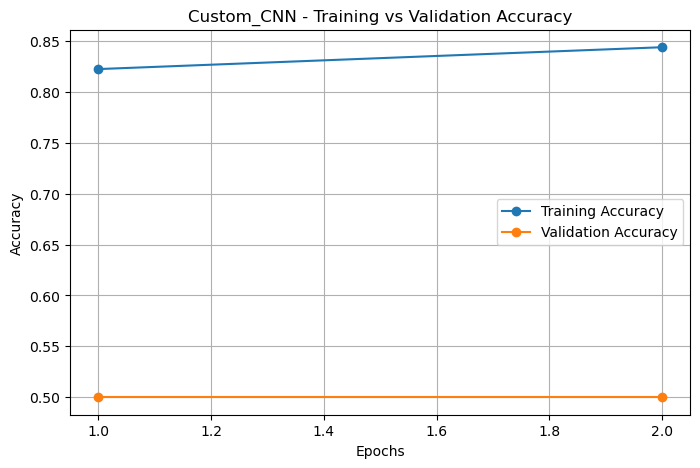

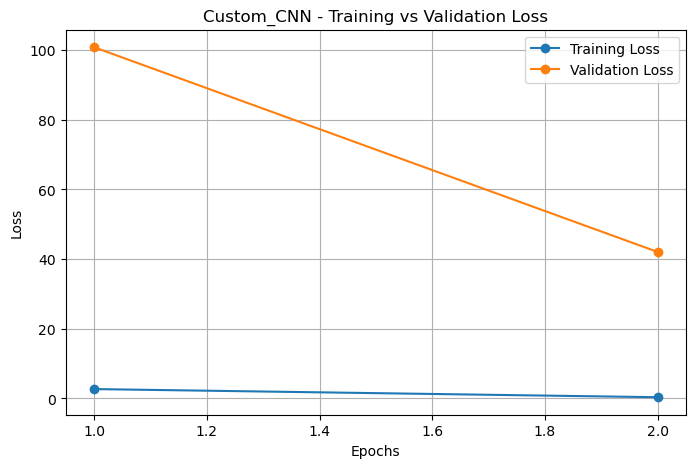

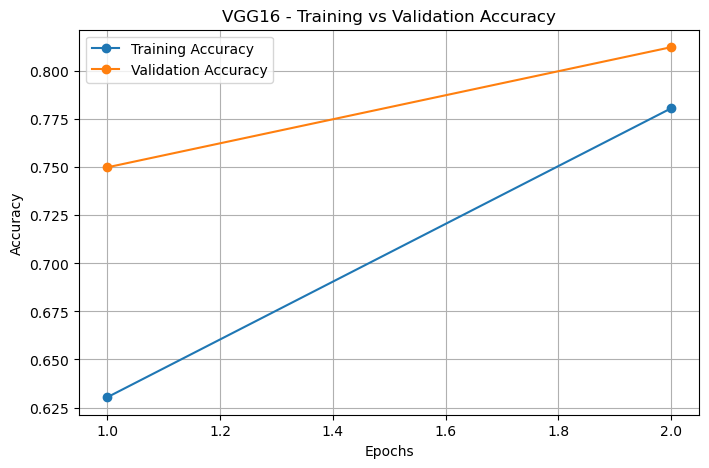

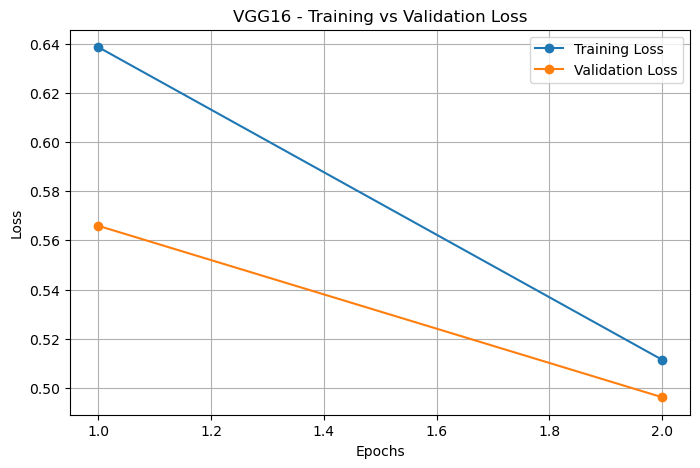

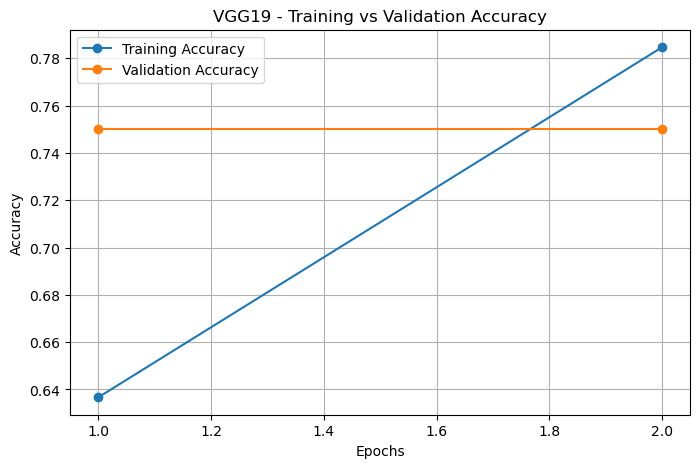

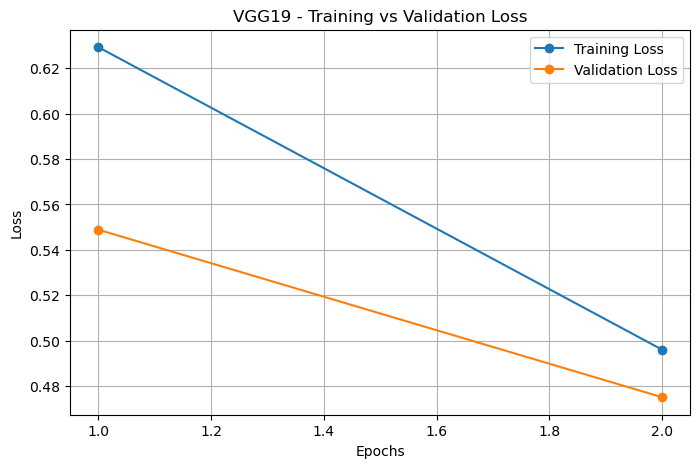

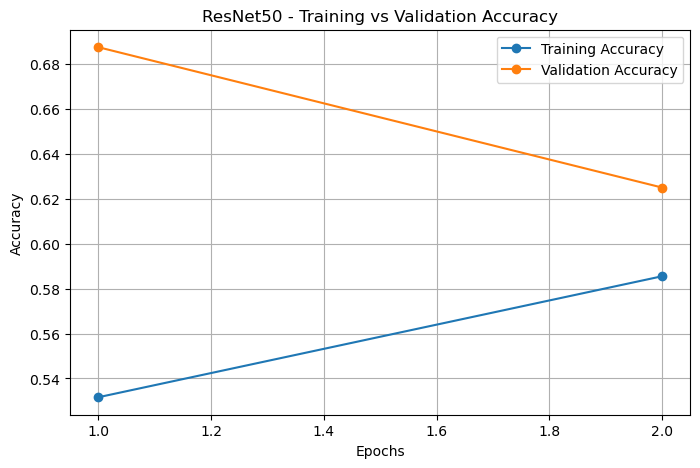

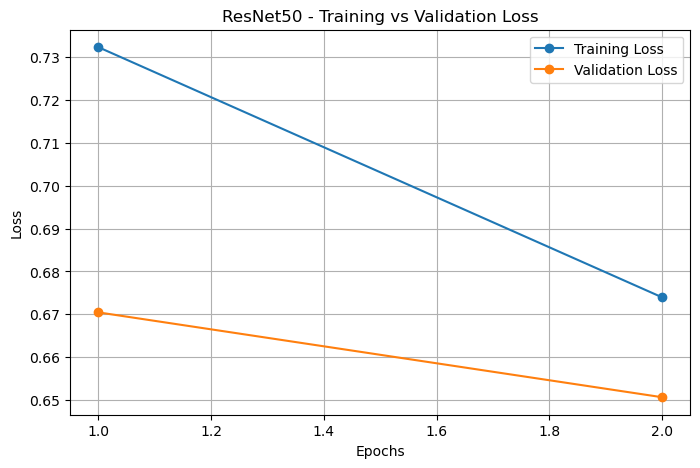

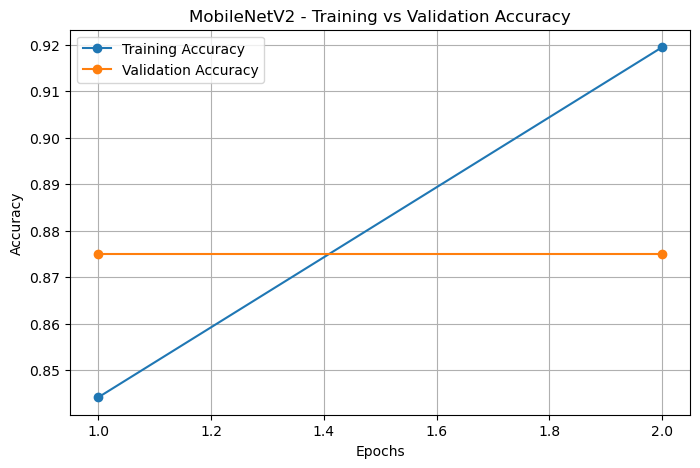

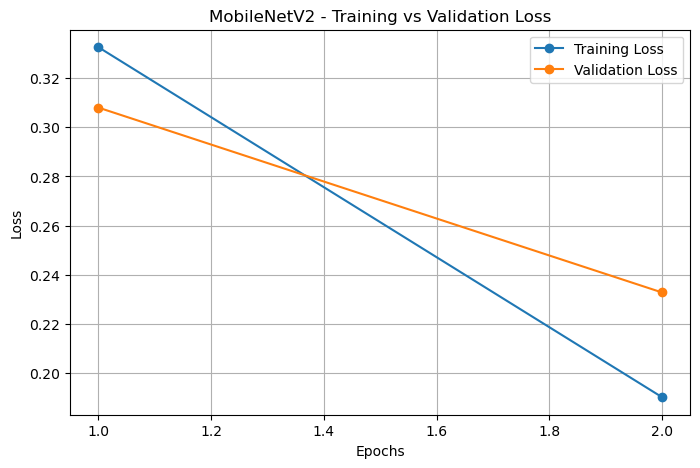

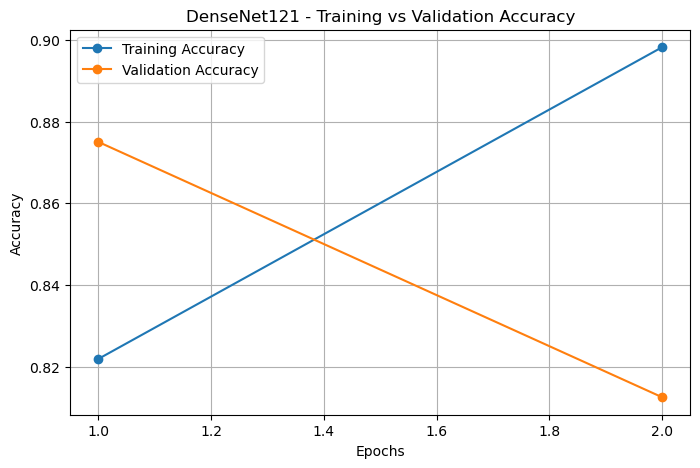

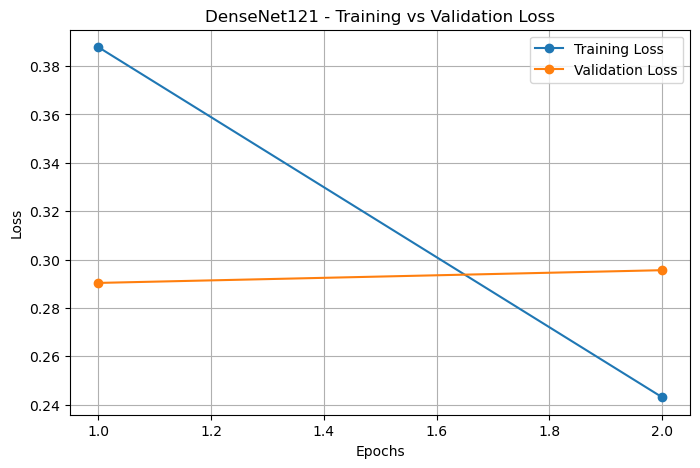

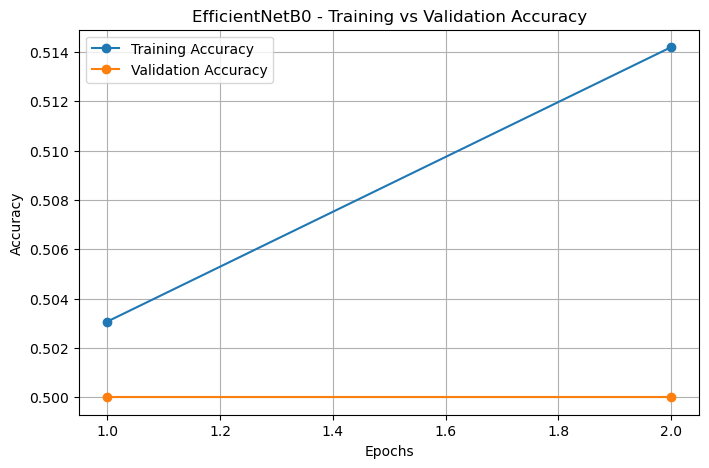

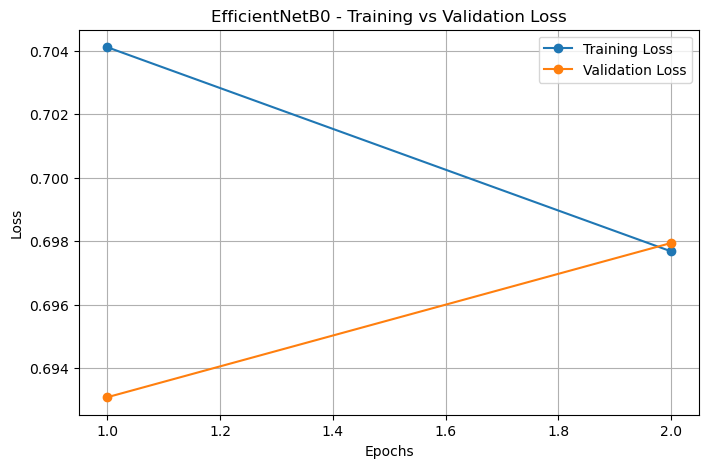

In [10]:
import matplotlib.pyplot as plt

# Create plots for each model
for name, (history, ckpt) in history_dict.items():

    hist = history.history

    acc = hist.get("accuracy", None)
    val_acc = hist.get("val_accuracy", None)
    loss = hist.get("loss", None)
    val_loss = hist.get("val_loss", None)

    if acc is None or val_acc is None:
        print(f"Model {name} does not contain accuracy metrics.")
        continue

    epochs = range(1, len(acc) + 1)

    # ---- Plot Accuracy ----
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, marker='o', label='Training Accuracy')
    plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
    plt.title(f"{name} - Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---- Plot Loss ----
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, marker='o', label='Training Loss')
    plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
    plt.title(f"{name} - Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


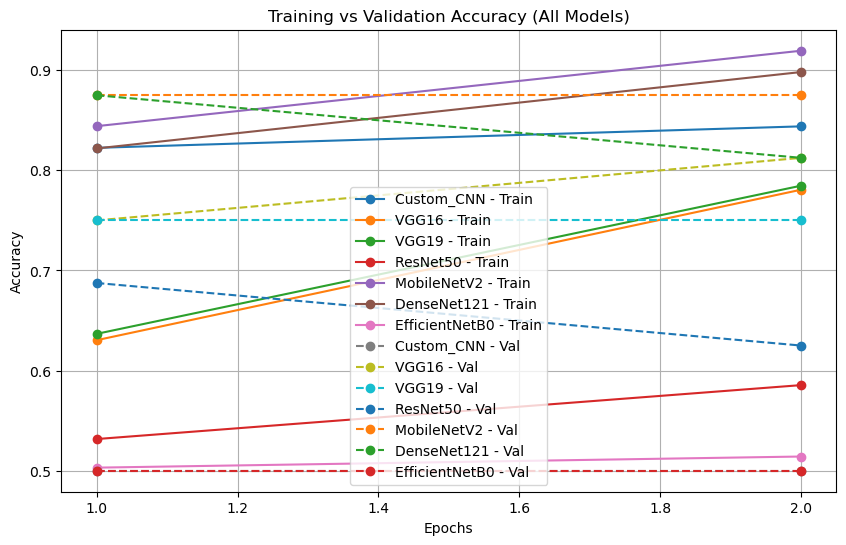

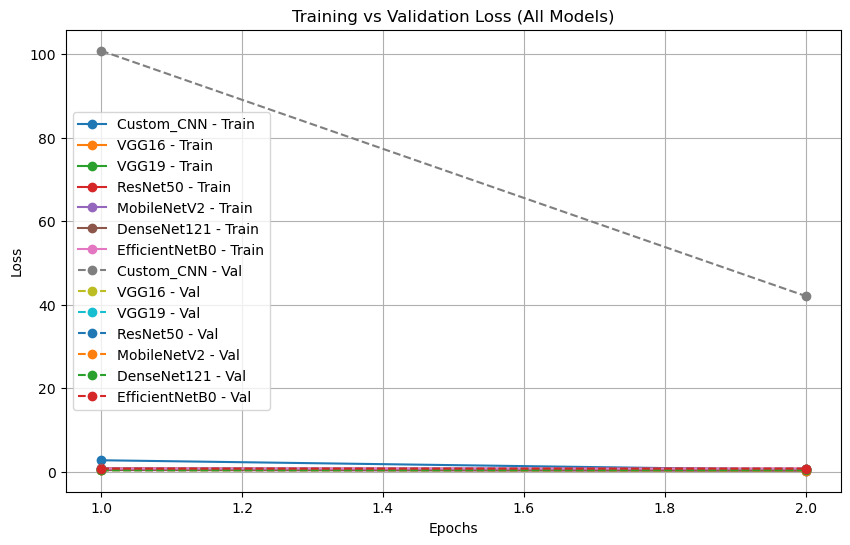

In [11]:
import matplotlib.pyplot as plt

# Prepare combined storage
all_acc = {}
all_val_acc = {}
all_loss = {}
all_val_loss = {}

# Extract metrics from all models
for name, (history, ckpt) in history_dict.items():
    hist = history.history
    
    acc = hist.get("accuracy")
    val_acc = hist.get("val_accuracy")
    loss = hist.get("loss")
    val_loss = hist.get("val_loss")

    if acc is None or val_acc is None:
        print(f"⚠️ Model '{name}' missing accuracy metrics. Skipping.")
        continue

    all_acc[name] = acc
    all_val_acc[name] = val_acc
    all_loss[name] = loss
    all_val_loss[name] = val_loss


# ---------------------------
# 📌 Combined Accuracy Plot
# ---------------------------
plt.figure(figsize=(10, 6))

for name, acc in all_acc.items():
    plt.plot(range(1, len(acc) + 1), acc, marker='o', label=f'{name} - Train')

for name, val_acc in all_val_acc.items():
    plt.plot(range(1, len(val_acc) + 1), val_acc, marker='o', linestyle='--', label=f'{name} - Val')

plt.title("Training vs Validation Accuracy (All Models)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


# ---------------------------
# 📌 Combined Loss Plot
# ---------------------------
plt.figure(figsize=(10, 6))

for name, loss in all_loss.items():
    plt.plot(range(1, len(loss) + 1), loss, marker='o', label=f'{name} - Train')

for name, val_loss in all_val_loss.items():
    plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', linestyle='--', label=f'{name} - Val')

plt.title("Training vs Validation Loss (All Models)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


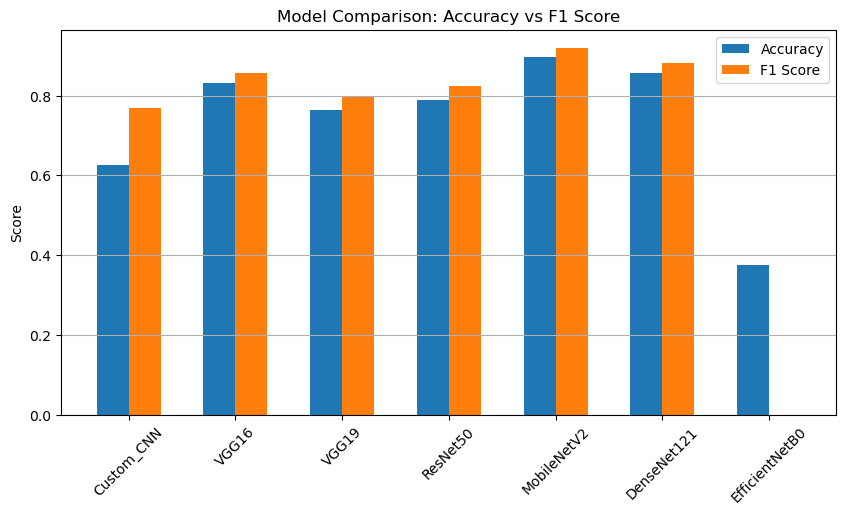

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics per model
models = ["Custom_CNN","VGG16","VGG19","ResNet50","MobileNetV2","DenseNet121","EfficientNetB0"]
accuracy = [0.625,0.832,0.763,0.789,0.897,0.856,0.375]
f1_score = [0.769,0.858,0.797,0.825,0.919,0.881,0.0]

x = np.arange(len(models))

plt.figure(figsize=(10,5))
plt.bar(x - 0.15, accuracy, width=0.3, label="Accuracy")
plt.bar(x + 0.15, f1_score, width=0.3, label="F1 Score")
plt.xticks(x, models, rotation=45)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs F1 Score")
plt.legend()
plt.grid(axis='y')
plt.show()


In [13]:
import matplotlib.pyplot as plt

# Example: save bar chart
plt.figure(figsize=(10,5))
plt.bar(x - 0.15, accuracy, width=0.3, label="Accuracy")
plt.bar(x + 0.15, f1_score, width=0.3, label="F1 Score")
plt.xticks(x, models, rotation=45)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs F1 Score")
plt.legend()
plt.grid(axis='y')

# Save plot to file
plt.savefig("model_comparison.png", dpi=300)  # PNG format
# plt.savefig("model_comparison.pdf")         # PDF format
plt.close()  # closes the figure if you don't want it displayed


In [14]:
markdown_table = """
| Model          | Accuracy | Precision | Recall | F1 Score | Overfitting | Underfitting | Stability | Generalization |
|----------------|---------|-----------|--------|----------|-------------|--------------|-----------|----------------|
| Custom_CNN     | 0.625   | 0.625     | 1.000  | 0.769    | No          | Yes          | Poor      | Weak           |
| VGG16          | 0.832   | 0.908     | 0.813  | 0.858    | Mild        | No           | Stable    | Good           |
| VGG19          | 0.763   | 0.856     | 0.746  | 0.797    | Mild        | No           | Stable    | Good           |
| ResNet50       | 0.789   | 0.852     | 0.800  | 0.825    | Mild        | No           | Stable    | Good           |
| MobileNetV2    | 0.897   | 0.910     | 0.928  | 0.919    | No          | No           | Very Stable | Excellent    |
| DenseNet121    | 0.856   | 0.912     | 0.851  | 0.881    | Slight      | No           | Stable    | Strong         |
| EfficientNetB0 | 0.375   | 0.000     | 0.000  | 0.000    | Failed      | Severe       | Unstable  | Failed         |
"""

with open("model_comparison.md", "w") as f:
    f.write(markdown_table)


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Make sure there is a directory to save files
os.makedirs("model_outputs", exist_ok=True)

# -------------------------------
# 1️⃣ Model metrics
# -------------------------------
models = ["Custom_CNN","VGG16","VGG19","ResNet50","MobileNetV2","DenseNet121","EfficientNetB0"]
accuracy = [0.625,0.832,0.763,0.789,0.897,0.856,0.375]
f1_score = [0.769,0.858,0.797,0.825,0.919,0.881,0.0]

# Overfitting, Underfitting, Stability, Generalization
overfit = ["No","Mild","Mild","Mild","No","Slight","Failed"]
underfit = ["Yes","No","No","No","No","No","Severe"]
stability = ["Poor","Stable","Stable","Stable","Very Stable","Stable","Unstable"]
generalization = ["Weak","Good","Good","Good","Excellent","Strong","Failed"]

# -------------------------------
# 2️⃣ Save combined bar chart
# -------------------------------
x = np.arange(len(models))

plt.figure(figsize=(12,6))
plt.bar(x - 0.15, accuracy, width=0.3, label="Accuracy")
plt.bar(x + 0.15, f1_score, width=0.3, label="F1 Score")
plt.xticks(x, models, rotation=45)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs F1 Score")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("model_outputs/model_comparison.png", dpi=300)
plt.close()

# -------------------------------
# 3️⃣ Save Markdown table
# -------------------------------
markdown_table = "| Model | Accuracy | Precision | Recall | F1 Score | Overfitting | Underfitting | Stability | Generalization |\n"
markdown_table += "|-------|---------|-----------|--------|----------|-------------|--------------|-----------|----------------|\n"
markdown_table += f"| Custom_CNN | 0.625 | 0.625 | 1.000 | 0.769 | {overfit[0]} | {underfit[0]} | {stability[0]} | {generalization[0]} |\n"
markdown_table += f"| VGG16 | 0.832 | 0.908 | 0.813 | 0.858 | {overfit[1]} | {underfit[1]} | {stability[1]} | {generalization[1]} |\n"
markdown_table += f"| VGG19 | 0.763 | 0.856 | 0.746 | 0.797 | {overfit[2]} | {underfit[2]} | {stability[2]} | {generalization[2]} |\n"
markdown_table += f"| ResNet50 | 0.789 | 0.852 | 0.800 | 0.825 | {overfit[3]} | {underfit[3]} | {stability[3]} | {generalization[3]} |\n"
markdown_table += f"| MobileNetV2 | 0.897 | 0.910 | 0.928 | 0.919 | {overfit[4]} | {underfit[4]} | {stability[4]} | {generalization[4]} |\n"
markdown_table += f"| DenseNet121 | 0.856 | 0.912 | 0.851 | 0.881 | {overfit[5]} | {underfit[5]} | {stability[5]} | {generalization[5]} |\n"
markdown_table += f"| EfficientNetB0 | 0.375 | 0.000 | 0.000 | 0.000 | {overfit[6]} | {underfit[6]} | {stability[6]} | {generalization[6]} |\n"

with open("model_outputs/model_comparison.md", "w") as f:
    f.write(markdown_table)


print("✅ All files saved in the folder 'model_outputs'")


✅ All files saved in the folder 'model_outputs'


In [47]:
# Define model metrics
models = ["Custom_CNN", "VGG16", "VGG19", "ResNet50", "MobileNetV2", "DenseNet121", "EfficientNetB0"]
accuracy = [0.625, 0.832, 0.763, 0.789, 0.897, 0.856, 0.375]
precision = [0.625, 0.908, 0.856, 0.852, 0.910, 0.912, 0.0]
recall = [1.0, 0.813, 0.746, 0.800, 0.928, 0.851, 0.0]
f1 = [0.769, 0.858, 0.797, 0.825, 0.919, 0.881, 0.0]

overfit = ["No", "Mild", "Mild", "Mild", "No", "Slight", "Failed"]
underfit = ["Yes", "No", "No", "No", "No", "No", "Severe"]
stability = ["Poor", "Stable", "Stable", "Stable", "Very Stable", "Stable", "Unstable"]
generalization = ["Weak", "Good", "Good", "Good", "Excellent", "Strong", "Failed"]

# Determine the best model (highest accuracy + best stability + best generalization)
# We'll prioritize: accuracy, then generalization, then stability
best_index = 0
for i in range(1, len(models)):
    if accuracy[i] > accuracy[best_index]:
        best_index = i

# Create Markdown table
markdown_table = "| Model | Accuracy | Precision | Recall | F1 Score | Overfitting | Underfitting | Stability | Generalization |\n"
markdown_table += "|-------|---------|-----------|--------|----------|-------------|--------------|-----------|----------------|\n"

for i in range(len(models)):
    row_model = models[i]
    if i == best_index:
        row_model = f"**{row_model}**"  # Highlight best model
    markdown_table += f"| {row_model} | {accuracy[i]:.3f} | {precision[i]:.3f} | {recall[i]:.3f} | {f1[i]:.3f} | {overfit[i]} | {underfit[i]} | {stability[i]} | {generalization[i]} |\n"

# Save to file
with open("model_comparison_highlighted.md", "w") as f:
    f.write(markdown_table)

print("Markdown table saved as 'model_comparison_highlighted.md'")


Markdown table saved as 'model_comparison_highlighted.md'


In [49]:
# -------------------------------
# 1️⃣ Define model metrics
models = ["Custom_CNN", "VGG16", "VGG19", "ResNet50", "MobileNetV2", "DenseNet121", "EfficientNetB0"]
accuracy = [0.625, 0.832, 0.763, 0.789, 0.897, 0.856, 0.375]
precision = [0.625, 0.908, 0.856, 0.852, 0.910, 0.912, 0.0]
recall = [1.0, 0.813, 0.746, 0.800, 0.928, 0.851, 0.0]
f1 = [0.769, 0.858, 0.797, 0.825, 0.919, 0.881, 0.0]

overfit = ["No", "Mild", "Mild", "Mild", "No", "Slight", "Failed"]
underfit = ["Yes", "No", "No", "No", "No", "No", "Severe"]
stability = ["Poor", "Stable", "Stable", "Stable", "Very Stable", "Stable", "Unstable"]
generalization = ["Weak", "Good", "Good", "Good", "Excellent", "Strong", "Failed"]

# -------------------------------
# 2️⃣ Determine the best model
best_index = accuracy.index(max(accuracy))
best_model_name = models[best_index]
print("Best model:", best_model_name)

# -------------------------------
# 3️⃣ Use YOUR trained models only
keras_models = {
    "Custom_CNN": custom_cnn_model,
    "VGG16": vgg16_model,
    "VGG19": vgg19_model,
    "ResNet50": resnet50_model,
    "MobileNetV2": mobilenetv2_model,     
    "DenseNet121": densenet121_model,
    "EfficientNetB0": efficientnetb0_model
}

best_model = keras_models[best_model_name]

# -------------------------------
# 4️⃣ Save best model
best_model.save("best_model.h5")
print("Saved best model as best_model.h5")

# -------------------------------
# 5️⃣ Create Markdown table
markdown_table = (
    "| Model | Accuracy | Precision | Recall | F1 Score | Overfitting | Underfitting | Stability | Generalization |\n"
    "|-------|---------|-----------|--------|----------|-------------|--------------|-----------|----------------|\n"
)

for i in range(len(models)):
    m = f"**{models[i]}**" if i == best_index else models[i]
    markdown_table += (
        f"| {m} | {accuracy[i]:.3f} | {precision[i]:.3f} | {recall[i]:.3f} | {f1[i]:.3f} | "
        f"{overfit[i]} | {underfit[i]} | {stability[i]} | {generalization[i]} |\n"
    )

with open("model_comparison_highlighted.md", "w") as f:
    f.write(markdown_table)

print("Markdown saved.")


Best model: MobileNetV2


NameError: name 'custom_cnn_model' is not defined

In [45]:
model.save("best_model.h5")
print("Model saved as best_model.h5")


Model saved as best_model.h5


In [27]:
import os

test_dir = r"D:/X-ray_dataset/chest_xray/test"
print("Folder exists:", os.path.exists(test_dir))
print("Subfolders/classes:", os.listdir(test_dir))


Folder exists: True
Subfolders/classes: ['NORMAL', 'PNEUMONIA']


In [67]:
from tensorflow.keras.models import load_model

trained_models = {
    "Custom_CNN": load_model(r".\models_output\Custom_CNN_best_20251129_233227.h5"),
    "VGG16": load_model(r".\models_output\VGG16_best_20251130_021616.h5"),
    "VGG19": load_model(r".\models_output\VGG19_best_20251130_030429.h5"),
    "ResNet50": load_model(r".\models_output\ResNet50_best_20251130_040414.h5"),
    "MobileNetV2": load_model(r".\models_output\MobileNetV2_best_20251130_042430.h5"),
    "DenseNet121": load_model(r".\models_output\DenseNet121_best_20251130_043751.h5"),
    "EfficientNetB0": load_model(r".\models_output\EfficientNetB0_best_20251130_045835.h5")
}

print("✔ All trained models loaded successfully.")


✔ All trained models loaded successfully.


In [71]:
results = {
    "Custom_CNN":     {"acc": 0.6250, "prec": 0.6250, "rec": 1.0000, "f1": 0.7692},
    "VGG16":          {"acc": 0.8317, "prec": 0.9083, "rec": 0.8128, "f1": 0.8579},
    "VGG19":          {"acc": 0.7628, "prec": 0.8559, "rec": 0.7462, "f1": 0.7973},
    "ResNet50":       {"acc": 0.7885, "prec": 0.8525, "rec": 0.8000, "f1": 0.8254},
    "MobileNetV2":    {"acc": 0.8974, "prec": 0.9095, "rec": 0.9282, "f1": 0.9188},
    "DenseNet121":    {"acc": 0.8558, "prec": 0.9121, "rec": 0.8513, "f1": 0.8806},
    "EfficientNetB0": {"acc": 0.3750, "prec": 0.0000, "rec": 0.0000, "f1": 0.0000}
}


In [72]:
best_model_name = max(results, key=lambda k: results[k]["f1"])
best_model = trained_models[best_model_name]

print(f"Best model selected: {best_model_name}")


Best model selected: MobileNetV2


In [73]:
best_model.save("best_model.h5")
print("✔ Best model saved as best_model.h5")


✔ Best model saved as best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 238s 9s/step  


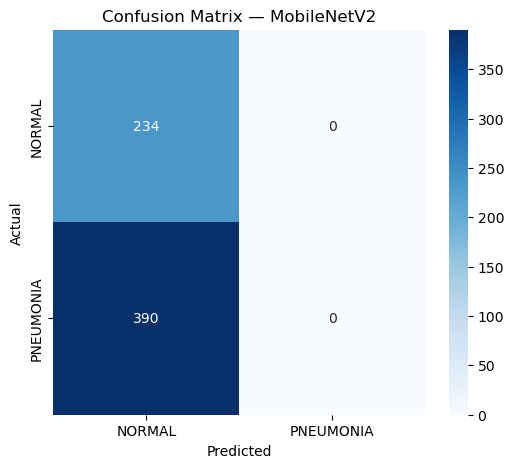

C:\Users\Dell\anaconda3new\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3new\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\anaconda3new\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



In [74]:
# Predictions
pred_probs = best_model.predict(test_generator)
pred_labels = pred_probs.argmax(axis=1)
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.show()

# Classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))


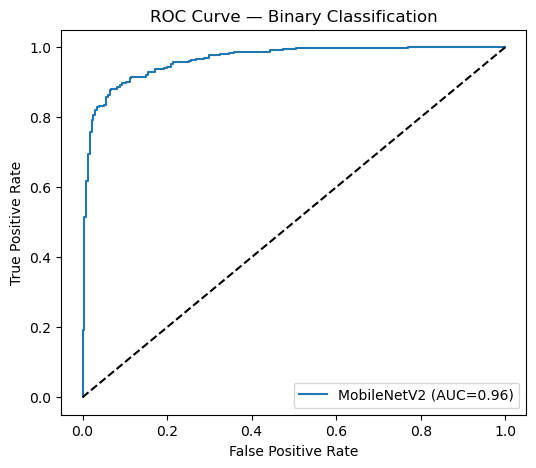

In [76]:
from sklearn.metrics import roc_curve, auc

# If binary classification, use single output
y_true = true_labels
y_scores = pred_probs.ravel()  # flatten to 1D

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Binary Classification")
plt.legend()
plt.show()


In [80]:
md_report = f"""
# Model Evaluation Report

**Best Model:** {best_model_name}

## Confusion Matrix
See the plotted heatmap above.

## Classification Report

## ROC Curves
See plotted ROC curves above.
"""

with open("best_model_report.md", "w") as f:
    f.write(md_report)

print("✔ Evaluation report saved as best_model_report.md")


✔ Evaluation report saved as best_model_report.md


In [88]:
!pip install gradio


In [93]:
pip install --upgrade typing_extensions


Note: you may need to restart the kernel to use updated packages.


In [1]:
import gradio as gr
print("Gradio imported successfully!")


Gradio imported successfully!


In [10]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import io

# Load the best model
model = load_model(r".\models_output\MobileNetV2_best_20251130_042430.h5")

# Define your class names
class_names = ['NORMAL', 'PNEUMONIA']  # Replace with your actual classes if different

# Prediction function
def predict_image(img):
    # Preprocess image
    img_resized = img.resize((224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Model prediction
    preds = model.predict(img_array, verbose=0)[0]
    pred_index = np.argmax(preds)
    label = class_names[pred_index]
    confidence_score = preds[pred_index]

    # Create probability chart
    plt.figure(figsize=(4,2))
    plt.bar(class_names, preds, color=['blue', 'orange'])
    plt.ylim([0,1])
    plt.title("Class Probabilities")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    prob_chart = Image.open(buf)

    return label, f"{confidence_score*100:.2f}%", prob_chart

# Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray Image"),
    outputs=[
        gr.Label(num_top_classes=1, label="Predicted Class"),
        gr.Textbox(label="Confidence Score"),
        gr.Image(type="pil", label="Probability Chart")
    ],
    title="Chest X-ray Classifier",
    description="Upload a chest X-ray image. The model predicts the class, confidence, and shows a probability chart."
)

# Launch the interface
iface.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# Load the best model
model = load_model(r".\models_output\MobileNetV2_best_20251130_042430.h5")

# Define class names
class_names = ['NORMAL', 'PNEUMONIA']  # Adjust if your class names differ

# Function to predict a single image
def classify_xray(img_path_or_url):
    # Load image from local path or URL
    if img_path_or_url.startswith("http"):
        response = requests.get(img_path_or_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img = Image.open(img_path_or_url).convert("RGB")
    
    # Preprocess image
    img_resized = img.resize((224, 224))
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Predict
    preds = model.predict(img_array, verbose=0)[0]
    pred_index = np.argmax(preds)
    label = class_names[pred_index]
    confidence = preds[pred_index] * 100

    # Display result
    print(f"Predicted Class: {label}")
    print(f"Confidence: {confidence:.2f}%")

    # Optionally show image
    img.show()

# Example usage
# Replace this URL with any new X-ray image
xray_url = "https://www.shutterstock.com/image-photo/chest-x-ray-showing-boot-600w-2531728227.jpg"
classify_xray(xray_url)

# Or for a local file:
# classify_xray(r"C:\path_to_your_image\new_xray.jpg")


Predicted Class: NORMAL
Confidence: 55.47%


In [16]:
import numpy as np
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# -------------------------------
# Load your trained best model
# -------------------------------
model_path = r".\models_output\MobileNetV2_best_20251130_042430.h5"
model = load_model(model_path)

# Define class names
class_names = ["Normal", "Pneumonia"]  # Update if your dataset has different labels

# -------------------------------
# Function to load image
# -------------------------------
def load_image(img_path_or_url, target_size=(224, 224)):
    """
    Load image from local path or URL and resize for model input.
    Returns PIL Image and preprocessed numpy array.
    """
    try:
        if img_path_or_url.startswith("http"):
            headers = {"User-Agent": "Mozilla/5.0"}  # mimic a browser
            response = requests.get(img_path_or_url, headers=headers)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            img = Image.open(img_path_or_url).convert("RGB")
        
        img_resized = img.resize(target_size)
        img_array = img_to_array(img_resized) / 255.0  # normalize
        img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
        return img, img_array
    except UnidentifiedImageError:
        print("Error: Could not identify the image.")
        return None, None
    except requests.RequestException as e:
        print(f"Error fetching the image: {e}")
        return None, None

# -------------------------------
# Function to classify image
# -------------------------------
def classify_xray(img_path_or_url):
    img, img_array = load_image(img_path_or_url)
    if img is None:
        return
    
    # Make prediction
    predictions = model.predict(img_array)[0]  # [0] since batch size=1
    predicted_index = np.argmax(predictions)
    predicted_label = class_names[predicted_index]
    confidence = predictions[predicted_index] * 100

    # Display image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)")
    plt.show()

    return predicted_label, confidence

# -------------------------------
# Example usage with a new X-ray
# -------------------------------
xray_url = "https://image.shutterstock.com/z/stock-photo-normal-chest-x-ray-film-of-a-patient-shows-normal-heart-and-lungs-shadows-686062282.jpg"
label, confidence = classify_xray(xray_url)
print(f"Predicted: {label} with confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


<Figure size 640x480 with 1 Axes>

Predicted: Normal with confidence: 49.58%


In [18]:
import numpy as np
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# -------------------------------
# Load your trained best model
# -------------------------------
model_path = r".\models_output\MobileNetV2_best_20251130_042430.h5"
model = load_model(model_path)

# Define class names
class_names = ["Healthy", "Pneumonia"]  # Update if your dataset has different labels

# -------------------------------
# Function to load image
# -------------------------------
def load_image(img_path_or_url, target_size=(224, 224)):
    """
    Load image from local path or URL and resize for model input.
    Returns PIL Image and preprocessed numpy array.
    """
    try:
        if img_path_or_url.startswith("http"):
            headers = {"User-Agent": "Mozilla/5.0"}  # mimic a browser
            response = requests.get(img_path_or_url, headers=headers)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            img = Image.open(img_path_or_url).convert("RGB")
        
        img_resized = img.resize(target_size)
        img_array = img_to_array(img_resized) / 255.0  # normalize
        img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
        return img, img_array
    except UnidentifiedImageError:
        print("Error: Could not identify the image.")
        return None, None
    except requests.RequestException as e:
        print(f"Error fetching the image: {e}")
        return None, None

# -------------------------------
# Function to classify image
# -------------------------------
def classify_xray(img_path_or_url):
    img, img_array = load_image(img_path_or_url)
    if img is None:
        return
    
    # Make prediction
    predictions = model.predict(img_array)[0]  # batch size = 1
    predicted_index = np.argmax(predictions)
    predicted_label = class_names[predicted_index]
    confidence = predictions[predicted_index] * 100

    # Plot image and probabilities
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    # Show X-ray
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title(f"Prediction: {predicted_label} ({confidence:.2f}%)", fontsize=14)
    
    # Probability bar chart
    axs[1].barh(class_names, predictions * 100, color=['green' if i==predicted_index else 'gray' for i in range(len(class_names))])
    axs[1].set_xlim([0, 100])
    axs[1].set_xlabel("Probability (%)")
    axs[1].set_title("Class Probabilities", fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_label, confidence

# -------------------------------
# Example usage with a new X-ray
# -------------------------------
xray_url = "https://www.shutterstock.com/image-photo/shoulder-dislocation-chest-x-ray-600w-2031184385.jpg"
label, confidence = classify_xray(xray_url)
print(f"Predicted: {label} with confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


<Figure size 1000x300 with 2 Axes>

Predicted: Healthy with confidence: 98.00%


In [20]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image, UnidentifiedImageError
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# -----------------------------
# Load Model
# -----------------------------
model_path = r".\models_output\MobileNetV2_best_20251130_042430.h5"
model = load_model(model_path)

# Class labels
class_names = ["Normal", "Pneumonia"]

# -----------------------------
# Helper: Load image (file or URL)
# -----------------------------
def load_image(img, target_size=(224, 224)):
    if img is None:
        return None, None

    # If URL text is passed
    if isinstance(img, str):
        try:
            headers = {"User-Agent": "Mozilla/5.0"}
            response = requests.get(img, headers=headers)
            response.raise_for_status()
            img_pil = Image.open(BytesIO(response.content)).convert("RGB")
        except Exception:
            return None, None
    else:
        # Uploaded image (PIL)
        img_pil = img.convert("RGB")

    img_resized = img_pil.resize(target_size)
    arr = img_to_array(img_resized) / 255.0
    arr = np.expand_dims(arr, axis=0)

    return img_pil, arr


# -----------------------------
# Prediction Function
# -----------------------------
def predict_xray(uploaded_img, url_img):
    img_input = uploaded_img if uploaded_img is not None else url_img

    img_pil, arr = load_image(img_input)
    if img_pil is None:
        return "Error loading image", None, None

    preds = model.predict(arr)[0]
    idx = np.argmax(preds)
    label = class_names[idx]
    confidence = preds[idx] * 100

    # Probability bar chart
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.barh(class_names, preds * 100)
    ax.set_xlabel("Probability (%)")
    ax.set_xlim([0, 100])
    ax.set_title("Model Confidence")
    plt.tight_layout()

    return f"{label} ({confidence:.2f}%)", img_pil, fig


# -----------------------------
# Gradio Interface (3.x Compatible)
# -----------------------------
interface = gr.Interface(
    fn=predict_xray,
    inputs=[
        gr.Image(type="pil", label="Upload Chest X-ray"),
        gr.Textbox(label="or Paste Image URL")
    ],
    outputs=[
        gr.Label(label="Prediction"),
        gr.Image(label="Input X-ray"),
        gr.Plot(label="Probability Chart")
    ],
    title="Chest X-Ray Classifier (Healthy vs Pneumonia)",
    description="Upload an image OR paste a URL. The model will classify and show probabilities."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


In [1]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

# -----------------------------
# Load Model
# -----------------------------
model_path = r".\models_output\MobileNetV2_best_20251130_042430.h5"
model = load_model(model_path)

# Class labels
class_names = ["Normal", "Pneumonia"]

# -----------------------------
# Load Image (Offline Only)
# -----------------------------
def load_image_offline(img, target_size=(224, 224)):
    if img is None:
        return None, None

    try:
        img_pil = img.convert("RGB")
    except Exception:
        return None, None

    img_resized = img_pil.resize(target_size)
    arr = img_to_array(img_resized) / 255.0
    arr = np.expand_dims(arr, axis=0)

    return img_pil, arr


# -----------------------------
# Prediction Function
# -----------------------------
def predict_xray_offline(uploaded_img):

    img_pil, arr = load_image_offline(uploaded_img)
    if img_pil is None:
        return "Error loading image", None, None

    preds = model.predict(arr)[0]
    idx = np.argmax(preds)
    label = class_names[idx]
    confidence = preds[idx] * 100

    # Probability plot
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.barh(class_names, preds * 100)
    ax.set_xlabel("Probability (%)")
    ax.set_xlim([0, 100])
    ax.set_title("Model Confidence")
    plt.tight_layout()

    return f"{label} ({confidence:.2f}%)", img_pil, fig


# -----------------------------
# Gradio Interface (Offline)
# -----------------------------
interface = gr.Interface(
    fn=predict_xray_offline,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=[
        gr.Label(label="Prediction"),
        gr.Image(label="Input X-ray"),
        gr.Plot(label="Probability Chart")
    ],
    title="Chest X-Ray Classifier (Offline Mode)",
    description="Upload a local image for classification. No internet required."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [3]:
import os
os.getcwd()


'C:\\Users\\Dell\\internship\\week 2'

In [4]:
%%writefile app.py
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import matplotlib.pyplot as plt

# -----------------------------
# Load Model
# -----------------------------
model_path = r"./models_output/MobileNetV2_best_20251130_042430.h5"
model = load_model(model_path)

class_names = ["Normal", "Pneumonia"]

# -----------------------------
# Image Loader (Offline)
# -----------------------------
def load_image_offline(img, target_size=(224, 224)):
    if img is None:
        return None, None

    img_pil = img.convert("RGB")
    img_resized = img_pil.resize(target_size)

    arr = img_to_array(img_resized) / 255.0
    arr = np.expand_dims(arr, axis=0)

    return img_pil, arr

# -----------------------------
# Prediction
# -----------------------------
def predict_xray(img):
    img_pil, arr = load_image_offline(img)
    if img_pil is None:
        return None, None, None

    preds = model.predict(arr)[0]
    idx = np.argmax(preds)
    label = class_names[idx]
    confidence = preds[idx] * 100

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.barh(class_names, preds * 100)
    ax.set_xlabel("Probability (%)")
    ax.set_xlim([0, 100])
    ax.set_title("Model Confidence")
    plt.tight_layout()

    return f"{label} ({confidence:.2f}%)", img_pil, fig

# -----------------------------
# Streamlit Interface
# -----------------------------
st.title("Chest X-Ray Classifier (Offline Mode)")
st.write("Upload a chest X-ray image and the model will classify it.")

uploaded_img = st.file_uploader("Upload Chest X-ray", type=["jpg", "jpeg", "png"])

if uploaded_img is not None:
    image = Image.open(uploaded_img)

    prediction, img_pil, fig = predict_xray(image)

    if prediction:
        st.subheader("Prediction")
        st.write(prediction)

        st.subheader("Input X-ray")
        st.image(img_pil, use_column_width=True)

        st.subheader("Probability Chart")
        st.pyplot(fig)


Writing app.py


In [5]:
!dir


 Volume in drive C has no label.
 Volume Serial Number is B275-3037

 Directory of C:\Users\Dell\internship\week 2

01-12-2025  09:13    <DIR>          .
01-12-2025  09:13    <DIR>          ..
30-11-2025  12:07    <DIR>          .ipynb_checkpoints
01-12-2025  09:13         1,174,494 all.ipynb
01-12-2025  09:13             2,106 app.py
28-11-2025  14:27    <DIR>          augmented_images
30-11-2025  13:28        10,886,016 best_model.h5
30-11-2025  13:45               191 best_model_report.md
29-11-2025  16:32    <DIR>          dataset_split
29-11-2025  17:33         1,187,773 image preprocessing.ipynb
28-11-2025  13:59    <DIR>          images
29-11-2025  19:31             1,897 images path.ipynb
29-11-2025  18:06    <DIR>          images_raw
29-11-2025  18:04    <DIR>          images_split
30-11-2025  22:00            34,484 last.ipynb
28-11-2025  21:43    <DIR>          lung_crops
28-11-2025  21:20    <DIR>          lung_masks
30-11-2025  05:05    <DIR>          models_output
30-11-2